<a href="https://colab.research.google.com/github/adrian-pieroni/challenge3_DataScience/blob/main/Challenge3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importación de las bibliotecas necesarias

In [1]:
import pandas as pd

Cargo el archivo base

In [8]:
df =pd.read_json('/content/TelecomX_Data (3).json')

In [9]:
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [15]:
import pandas as pd
import json # Import json for potential stringified JSON

# Assuming your DataFrame is already loaded and named 'df'
# If not, you'd load it first, e.g.: df = pd.read_json('your_data_file.json')

# --- Step 1: Unpack Nested JSON Columns ---
# (Re-running this just in case, but the focus is on fixing Step 2)

df_flat = df.copy()
nested_columns = ['customer', 'phone', 'internet', 'account']

for col in nested_columns:
    # Check if the column actually contains dictionary-like objects
    # It might be stringified JSON for some rows, or direct dicts for others
    # We'll try to convert to dict if it's a string, then expand.

    # Try to convert stringified JSON to actual dicts first
    # This ensures consistency before applying pd.Series
    def parse_json_string(item):
        if isinstance(item, str):
            try:
                return json.loads(item)
            except json.JSONDecodeError:
                return item # Return original if it's just a regular string
        return item # Return item as is if it's already a dict or not a string

    df_flat[col] = df_flat[col].apply(parse_json_string)

    if isinstance(df_flat[col].iloc[0], dict): # Check the first element's type again
        expanded_data = df_flat[col].apply(pd.Series).add_prefix(f'{col}_')
        df_flat = pd.concat([df_flat, expanded_data], axis=1)
        df_flat = df_flat.drop(columns=[col])
    else:
        print(f"Column '{col}' still contains non-dictionary objects after initial parsing or was not a dict to begin with. Skipping expansion for this column.")
        # If a column remains an 'object' type here and contains mixed data
        # (e.g., dicts and strings), you'll need more specific handling.
        # For this challenge, we assume it's primarily dicts to be expanded.


print("DataFrame after unpacking nested columns (re-attempt):")
df_flat.info()

# --- Step 2: Convert Data Types and Handle Initial Missing Values (Improved) ---

# Convert 'Churn' column to numerical (target variable)
df_flat['Churn'] = df_flat['Churn'].map({'Yes': 1, 'No': 0})
print("\n'Churn' column converted to numerical.")

# Iterate through all columns to identify and convert types
for col in df_flat.columns:
    if col == 'customerID':
        continue # customerID is an identifier, keep as is

    # Check for any remaining dictionary or list objects in the column
    # Convert them to string representation if found, to make them hashable/processible
    # This is key to resolve 'unhashable type: dict'
    if df_flat[col].apply(lambda x: isinstance(x, (dict, list))).any():
        print(f"Warning: Column '{col}' still contains dictionaries or lists. Converting to string.")
        df_flat[col] = df_flat[col].astype(str) # Convert entire column to string
        # After converting to string, it might still need to be handled as categorical or parsed if needed.

    if df_flat[col].dtype == 'object':
        # Handle 'TotalCharges' specifically
        if 'TotalCharges' in col:
            df_flat[col] = df_flat[col].replace(' ', pd.NA)
            df_flat[col] = pd.to_numeric(df_flat[col], errors='coerce') # 'coerce' will turn unconvertible values into NaN
            print(f"Column '{col}' converted to numeric (float), handling spaces.")

        else: # For other object columns
            # Try converting to numeric first
            converted_to_numeric = pd.to_numeric(df_flat[col], errors='coerce')

            # Check how many NaNs were introduced by coercion
            # If a small number of non-numeric values (that aren't already NA),
            # it's likely a numeric column with some 'dirty' data.
            initial_nans = df_flat[col].isnull().sum()
            coerced_nans = converted_to_numeric.isnull().sum()

            # Heuristic: if coercion didn't add too many new NaNs (e.g., less than 5% of rows)
            # AND there are a significant number of numeric values, treat as numeric.
            # This logic might need adjustment based on your specific data characteristics.
            if coerced_nans - initial_nans < 0.05 * len(df_flat) and converted_to_numeric.notna().sum() > 0.5 * len(df_flat):
                df_flat[col] = converted_to_numeric
                print(f"Column '{col}' mostly numeric, converted to numeric (float).")
            else:
                # If not primarily numeric, convert to 'category'
                df_flat[col] = df_flat[col].astype('category')
                print(f"Column '{col}' converted to categorical.")

print("\nDataFrame after improved type conversions:")
df_flat.info()

print("\nMissing values after initial processing:")
print(df_flat.isnull().sum()[df_flat.isnull().sum() > 0])


# --- Step 3: Handle Remaining Missing Values ---

# Impute numerical columns with missing values (e.g., customer_TotalCharges)
# Median is generally preferred for numerical imputation as it's robust to outliers.
for col in df_flat.select_dtypes(include=['number']).columns:
    if df_flat[col].isnull().any():
        median_val = df_flat[col].median()
        df_flat[col].fillna(median_val, inplace=True)
        print(f"Missing values in numerical column '{col}' imputed with median: {median_val}")

# Impute categorical columns with missing values (e.g., if any categorical column ended up with NaNs)
for col in df_flat.select_dtypes(include=['category']).columns:
    if df_flat[col].isnull().any():
        # Mode is generally appropriate for categorical imputation
        mode_val = df_flat[col].mode()[0]
        df_flat[col].fillna(mode_val, inplace=True)
        print(f"Missing values in categorical column '{col}' imputed with mode: '{mode_val}'")


print("\nFinal check for missing values:")
print(df_flat.isnull().sum()[df_flat.isnull().sum() > 0])

print("\nDataFrame ready for next steps (feature engineering, encoding, scaling):")
df_flat.head()
df_flat.info()

DataFrame after unpacking nested columns (re-attempt):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   customerID                 7267 non-null   object
 1   Churn                      7267 non-null   object
 2   customer_gender            7267 non-null   object
 3   customer_SeniorCitizen     7267 non-null   int64 
 4   customer_Partner           7267 non-null   object
 5   customer_Dependents        7267 non-null   object
 6   customer_tenure            7267 non-null   int64 
 7   phone_PhoneService         7267 non-null   object
 8   phone_MultipleLines        7267 non-null   object
 9   internet_InternetService   7267 non-null   object
 10  internet_OnlineSecurity    7267 non-null   object
 11  internet_OnlineBackup      7267 non-null   object
 12  internet_DeviceProtection  7267 non-null   object
 13  internet

/tmp/ipython-input-15-3708754022.py:105: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_flat[col].fillna(median_val, inplace=True)


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Assuming df_flat is your preprocessed DataFrame from the previous steps
# If you don't have it in your current environment, you'd need to re-run
# the data loading and preprocessing steps.

# --- 1. Define Features (X) and Target (y) ---
# 'Churn' is our target variable. 'customerID' is an identifier and should be dropped.

X = df_flat.drop(columns=['Churn', 'customerID'])
y = df_flat['Churn']

print("Shape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# --- 2. Identify Categorical and Numerical Columns ---
# We need to distinguish between them for different preprocessing steps.

# Select columns with 'category' dtype
categorical_features = X.select_dtypes(include=['category']).columns
# Select columns with 'int64', 'float64' dtypes (or any numerical dtype)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

print(f"\nCategorical features ({len(categorical_features)}): {list(categorical_features)}")
print(f"Numerical features ({len(numerical_features)}): {list(numerical_features)}")

# --- 3. Create Preprocessing Pipelines ---
# We'll use ColumnTransformer to apply different transformations to different columns.
# This makes our preprocessing robust and easy to integrate with model training.

# Preprocessor for numerical features (StandardScaler for normalization)
numerical_transformer = StandardScaler()

# Preprocessor for categorical features (OneHotEncoder for one-hot encoding)
# handle_unknown='ignore' ensures that if new categories appear in test set, it won't error out.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any other columns not specified (e.g., if you added boolean flags)
)

print("\nPreprocessor created for numerical and categorical features.")

# --- 4. Split Data into Training and Testing Sets ---
# This is where X_train, X_test, y_train, y_test are defined.
# stratify=y is important for imbalanced datasets like churn to maintain
# the same proportion of churners in both train and test sets.
# random_state for reproducibility.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split into training and testing sets:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- 5. Build the Full Machine Learning Pipeline ---
# Combine preprocessing with the model into a single pipeline.

# Initialize the Logistic Regression model
model = LogisticRegression(solver='liblinear', random_state=42) # 'liblinear' is good for small datasets and L1/L2 regularization

# Create the full pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

print("\nFull pipeline (preprocessing + Logistic Regression) created.")

# --- 6. Train the Model ---
# The .fit() method now applies all preprocessing steps (fit_transform on training data)
# and then trains the Logistic Regression model.

full_pipeline.fit(X_train, y_train)

print("\n¡Modelo de Regresión Logística entrenado con éxito!")

# --- 7. Evaluate the Model ---
# Make predictions on the test set and evaluate performance.

y_pred = full_pipeline.predict(X_test)
y_proba = full_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (churn=1)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- 8. Interpretation (for Logistic Regression) ---
# For Logistic Regression, you can get coefficients after training.
# You need to inverse transform the scaled data or get feature names from OneHotEncoder.
# This part is more involved because of the pipeline.

# Get feature names after one-hot encoding
# This requires fitting the preprocessor separately to get feature names
# or accessing them from the fitted pipeline.
fitted_preprocessor = full_pipeline.named_steps['preprocessor']
ohe_feature_names = fitted_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

# Get the coefficients from the trained Logistic Regression model
coefficients = full_pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame for better visualization
feature_importance_lr = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Logistic Regression Feature Coefficients (Importance) ---")
print(feature_importance_lr.head(10)) # Top 10 most influential features for churn (positive coefficients)
print(feature_importance_lr.tail(10)) # Top 10 most influential features against churn (negative coefficients)

Shape of X (features): (7267, 18)
Shape of y (target): (7267,)

Categorical features (16): ['customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges']
Numerical features (2): ['customer_SeniorCitizen', 'customer_tenure']

Preprocessor created for numerical and categorical features.

Data split into training and testing sets:
X_train shape: (5813, 18)
X_test shape: (1454, 18)
y_train shape: (5813,)
y_test shape: (1454,)

Full pipeline (preprocessing + Logistic Regression) created.

¡Modelo de Regresión Logística entrenado con éxito!

--- Model Evaluation ---
Accuracy: 0.8026
ROC AUC Score: 0.8414

Classification Report:
               precision    recall  f1-score   s

Características numéricas para análisis de correlación (2):
['customer_SeniorCitizen', 'customer_tenure']

Matriz de Correlación (primeras 5x5 filas/columnas si es muy grande):
                        customer_SeniorCitizen  customer_tenure
customer_SeniorCitizen                1.000000         0.018187
customer_tenure                       0.018187         1.000000


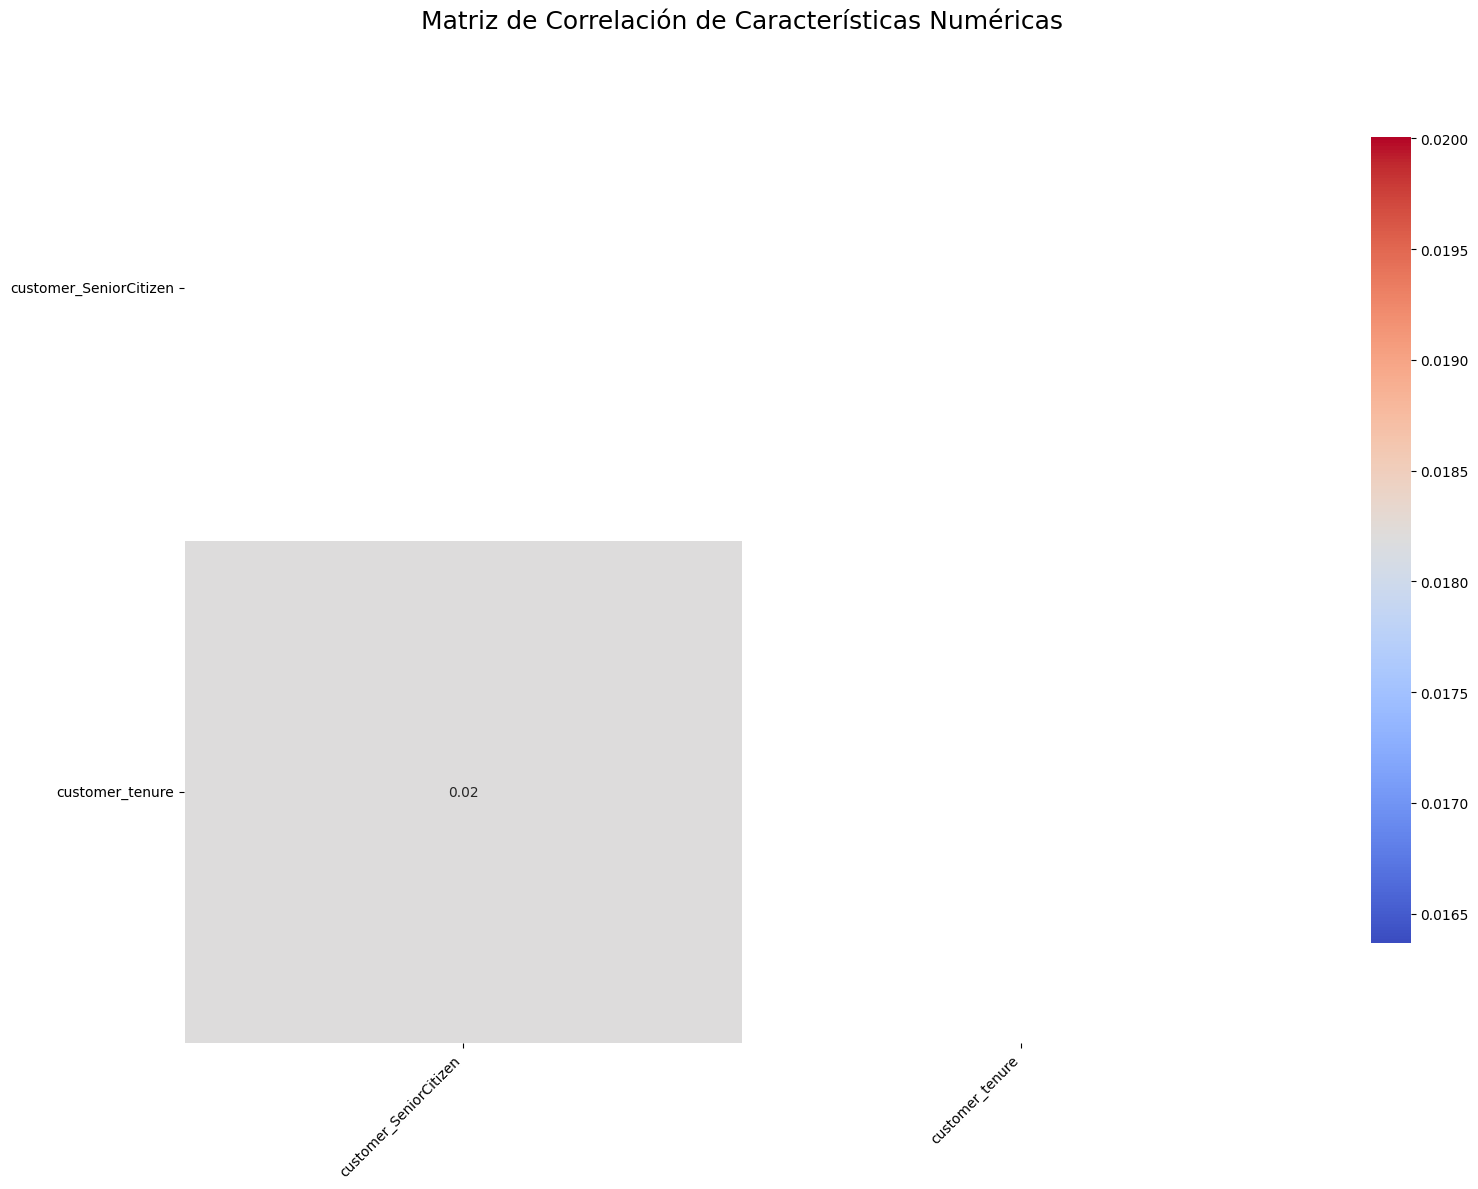


No se encontraron pares de características numéricas con una correlación absoluta mayor a 0.75.

--- Correlación de Características Numéricas con 'Churn' ---
customer_SeniorCitizen    0.146733
customer_tenure          -0.344079
Name: Churn, dtype: float64


/tmp/ipython-input-18-872971484.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_churn.values, y=correlation_with_churn.index, palette='viridis')


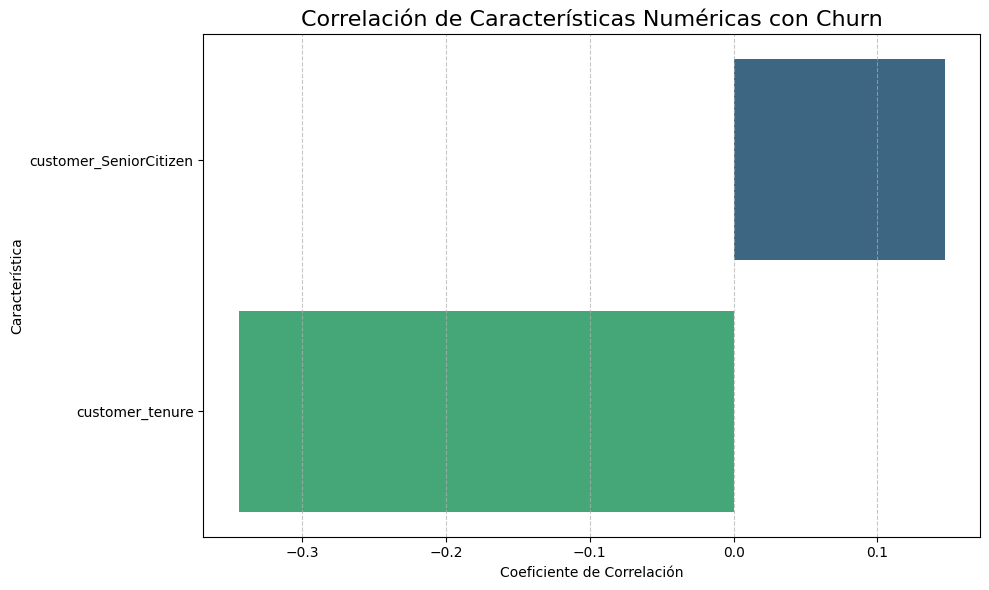


--- Interpretación de la Correlación con Churn ---
  - Valores positivos: A medida que la característica aumenta, la probabilidad de churn tiende a aumentar.
  - Valores negativos: A medida que la característica aumenta, la probabilidad de churn tiende a disminuir.
  - La fuerza de la relación está indicada por el valor absoluto del coeficiente.


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy for np.triu

# Assuming df_flat is your preprocessed DataFrame from the previous steps.
# If not, ensure you run all the data loading and preprocessing code first.

# --- 1. Identificar Características Numéricas ---
# Seleccionar solo las columnas con tipos de datos numéricos
# (float64, int64). 'Churn' es el objetivo, 'customerID' es un identificador.
numerical_features = df_flat.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Excluir 'Churn' (nuestra variable objetivo) y 'customerID' de las características para correlación
if 'Churn' in numerical_features:
    numerical_features.remove('Churn')
if 'customerID' in numerical_features:
    numerical_features.remove('customerID')

print(f"Características numéricas para análisis de correlación ({len(numerical_features)}):")
print(numerical_features)

# --- 2. Calcular la Matriz de Correlación ---
# Calcula la matriz de correlación de Pearson para las características numéricas.
correlation_matrix = df_flat[numerical_features].corr()

print("\nMatriz de Correlación (primeras 5x5 filas/columnas si es muy grande):")
print(correlation_matrix.head(5).iloc[:, :5])


# --- 3. Visualizar la Matriz de Correlación con un Heatmap ---
# Un heatmap es excelente para visualizar las correlaciones.

plt.figure(figsize=(16, 12)) # Ajusta el tamaño para una mejor visualización

# Crear una máscara para la triangular superior (para evitar duplicados y mejorar la lectura)
mask = np.triu(correlation_matrix)

sns.heatmap(
    correlation_matrix,
    annot=True,        # Mostrar los valores de correlación en el heatmap
    cmap='coolwarm',   # Mapa de colores (coolwarm es bueno para correlaciones positivas/negativas)
    fmt=".2f",         # Formato para los valores (2 decimales)
    linewidths=.5,     # Líneas entre celdas
    mask=mask,         # Aplicar la máscara
    cbar_kws={"shrink": .8} # Ajustar el tamaño de la barra de color
)
plt.title('Matriz de Correlación de Características Numéricas', fontsize=18)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas para que sean legibles
plt.yticks(rotation=0)
plt.tight_layout() # Ajustar el diseño para que todo quepa
plt.show()

# --- 4. Identificar Pares de Características con Alta Correlación ---
# Buscamos características que estén altamente correlacionadas (positiva o negativamente).
# Un umbral común es |correlación| > 0.7 o 0.8.

high_corr_threshold = 0.75 # Puedes ajustar este umbral

highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i): # Solo la parte inferior de la matriz
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            highly_correlated_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

if highly_correlated_pairs:
    print(f"\n--- Pares de Características Numéricas con Correlación Absoluta > {high_corr_threshold} ---")
    for col1, col2, corr_val in highly_correlated_pairs:
        print(f"  - '{col1}' y '{col2}': Correlación = {corr_val:.2f}")
    print("\nConsideraciones para alta correlación:")
    print("  - La multicolinealidad (variables predictoras altamente correlacionadas entre sí)")
    print("    puede afectar a la interpretabilidad de modelos lineales (como la Regresión Logística).")
    print("  - Para modelos basados en árboles (Random Forest, XGBoost), suele ser menos problemático,")
    print("    pero identificar estas relaciones aún es útil para entender tus datos.")
    print("  - Podrías considerar eliminar una de las variables altamente correlacionadas si ambas miden lo mismo.")
else:
    print(f"\nNo se encontraron pares de características numéricas con una correlación absoluta mayor a {high_corr_threshold}.")

# --- 5. Correlación de Características Numéricas con la Variable Objetivo (Churn) ---
# Esto te da una idea de qué tan fuerte es la relación lineal entre cada característica y el churn.

# Calcular la correlación de todas las características con 'Churn'
correlation_with_churn = df_flat[numerical_features + ['Churn']].corr()['Churn'].sort_values(ascending=False)

# Excluir la correlación de 'Churn' consigo mismo
correlation_with_churn = correlation_with_churn.drop('Churn')

print("\n--- Correlación de Características Numéricas con 'Churn' ---")
print(correlation_with_churn)

# Visualizar la correlación con Churn
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_churn.values, y=correlation_with_churn.index, palette='viridis')
plt.title('Correlación de Características Numéricas con Churn', fontsize=16)
plt.xlabel('Coeficiente de Correlación')
plt.ylabel('Característica')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n--- Interpretación de la Correlación con Churn ---")
print("  - Valores positivos: A medida que la característica aumenta, la probabilidad de churn tiende a aumentar.")
print("  - Valores negativos: A medida que la característica aumenta, la probabilidad de churn tiende a disminuir.")
print("  - La fuerza de la relación está indicada por el valor absoluto del coeficiente.")

Datos divididos y listos para entrenar múltiples modelos.

--- Entrenando y Evaluando Regresión Logística ---
Regresión Logística - Accuracy: 0.8026
Regresión Logística - ROC AUC Score: 0.8414
Regresión Logística - Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1080
         1.0       0.64      0.53      0.58       374

    accuracy                           0.80      1454
   macro avg       0.74      0.72      0.73      1454
weighted avg       0.79      0.80      0.80      1454


--- Entrenando y Evaluando Random Forest Classifier ---
Random Forest - Accuracy: 0.7785
Random Forest - ROC AUC Score: 0.8130
Random Forest - Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1080
         1.0       0.59      0.46      0.52       374

    accuracy                           0.78      1454
   macro avg       0.71      0.68      0.69     

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:12:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Accuracy: 0.7572
XGBoost - ROC AUC Score: 0.8221
XGBoost - Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.77      0.83      1080
         1.0       0.52      0.71      0.60       374

    accuracy                           0.76      1454
   macro avg       0.70      0.74      0.71      1454
weighted avg       0.79      0.76      0.77      1454


--- Comparando Modelos con Curvas ROC ---


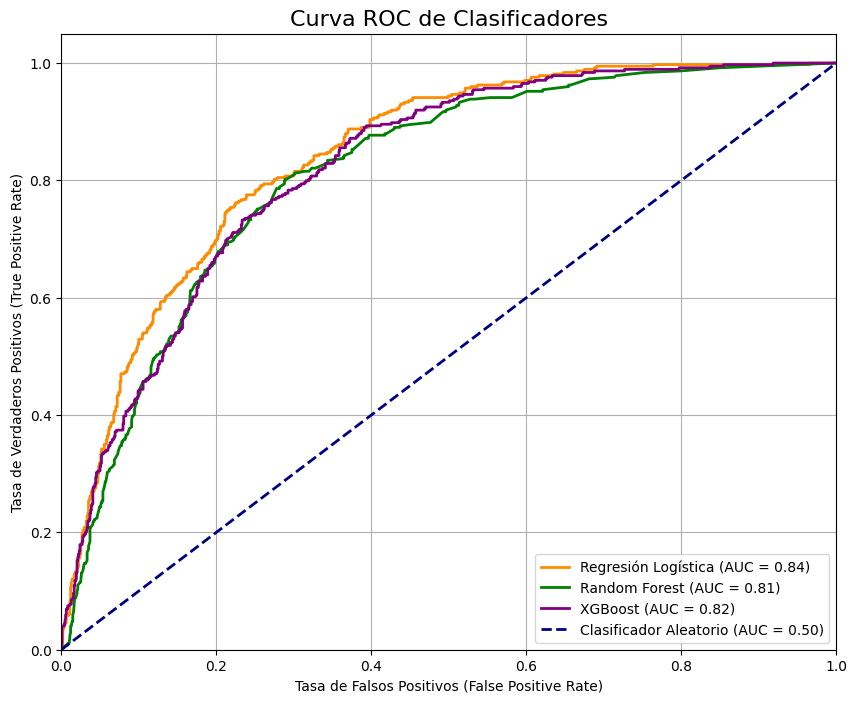


--- Resumen de Rendimiento (ROC AUC) ---
Regresión Logística ROC AUC: 0.8414
Random Forest ROC AUC:     0.8130
XGBoost ROC AUC:           0.8221


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Importar los nuevos modelos
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # Asegúrate de tener xgboost instalado: pip install xgboost

# Importar métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Asumiendo que df_flat está cargado y preprocesado desde los pasos anteriores ---
# Si no tienes df_flat en tu entorno, debes ejecutar el código de los pasos 1, 2 y 3 de preparación.

# --- Definir Features (X) y Target (y) nuevamente ---
X = df_flat.drop(columns=['Churn', 'customerID'])
y = df_flat['Churn']

# --- Identificar Categorical y Numerical Columns nuevamente ---
categorical_features = X.select_dtypes(include=['category']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# --- Crear Preprocessing Pipelines (reusando la lógica) ---
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# --- Dividir los datos en conjuntos de entrenamiento y prueba (reusando la división anterior) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Datos divididos y listos para entrenar múltiples modelos.")

# --- 1. Modelo 1: Regresión Logística (ya entrenado, pero lo definimos para comparación) ---
print("\n--- Entrenando y Evaluando Regresión Logística ---")
log_reg_model = LogisticRegression(solver='liblinear', random_state=42)
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', log_reg_model)])
log_reg_pipeline.fit(X_train, y_train)

y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

print(f"Regresión Logística - Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Regresión Logística - ROC AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")
print("Regresión Logística - Classification Report:\n", classification_report(y_test, y_pred_lr))

# --- 2. Modelo 2: Random Forest Classifier ---
print("\n--- Entrenando y Evaluando Random Forest Classifier ---")
# Puedes ajustar los hiperparámetros (ej., n_estimators, max_depth) más tarde con tuning
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # 'balanced' ayuda con desbalance de clases
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', rf_model)])
rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print(f"Random Forest - Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Random Forest - ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")
print("Random Forest - Classification Report:\n", classification_report(y_test, y_pred_rf))

# --- 3. Modelo 3: XGBoost Classifier ---
print("\n--- Entrenando y Evaluando XGBoost Classifier ---")
# Para XGBoost con datasets desbalanceados, `scale_pos_weight` es útil o `eval_metric='auc'`
# Calcula scale_pos_weight = count(negative examples) / count(positive examples)
scale_pos_weight_val = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', # O 'auc' para monitorear durante el entrenamiento
    use_label_encoder=False, # Suprime la advertencia de un uso futuro deprecado
    n_estimators=100,
    random_state=42,
    scale_pos_weight=scale_pos_weight_val # Ayuda a manejar el desbalance de clases
)
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb_model)])
xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

print(f"XGBoost - Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"XGBoost - ROC AUC Score: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print("XGBoost - Classification Report:\n", classification_report(y_test, y_pred_xgb))


# --- 4. Comparación Visual de Curvas ROC ---
print("\n--- Comparando Modelos con Curvas ROC ---")

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Regresión Logística (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='purple', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate)')
plt.title('Curva ROC de Clasificadores', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\n--- Resumen de Rendimiento (ROC AUC) ---")
print(f"Regresión Logística ROC AUC: {roc_auc_lr:.4f}")
print(f"Random Forest ROC AUC:     {roc_auc_rf:.4f}")
print(f"XGBoost ROC AUC:           {roc_auc_xgb:.4f}")


Total features after preprocessing: 5525

--- Random Forest Feature Importance ---
                                   Feature  Importance
1                          customer_tenure    0.111125
34         account_Contract_Month-to-month    0.044353
16              internet_OnlineSecurity_No    0.028104
36               account_Contract_Two year    0.025220
25                 internet_TechSupport_No    0.023835
14    internet_InternetService_Fiber optic    0.023111
41  account_PaymentMethod_Electronic check    0.022762
35               account_Contract_One year    0.019950
27                internet_TechSupport_Yes    0.017202
19                internet_OnlineBackup_No    0.016335

--- XGBoost Feature Importance ---
                                   Feature  Importance
34         account_Contract_Month-to-month    0.465547
14    internet_InternetService_Fiber optic    0.077375
15             internet_InternetService_No    0.024018
35               account_Contract_One year    0.022537
1

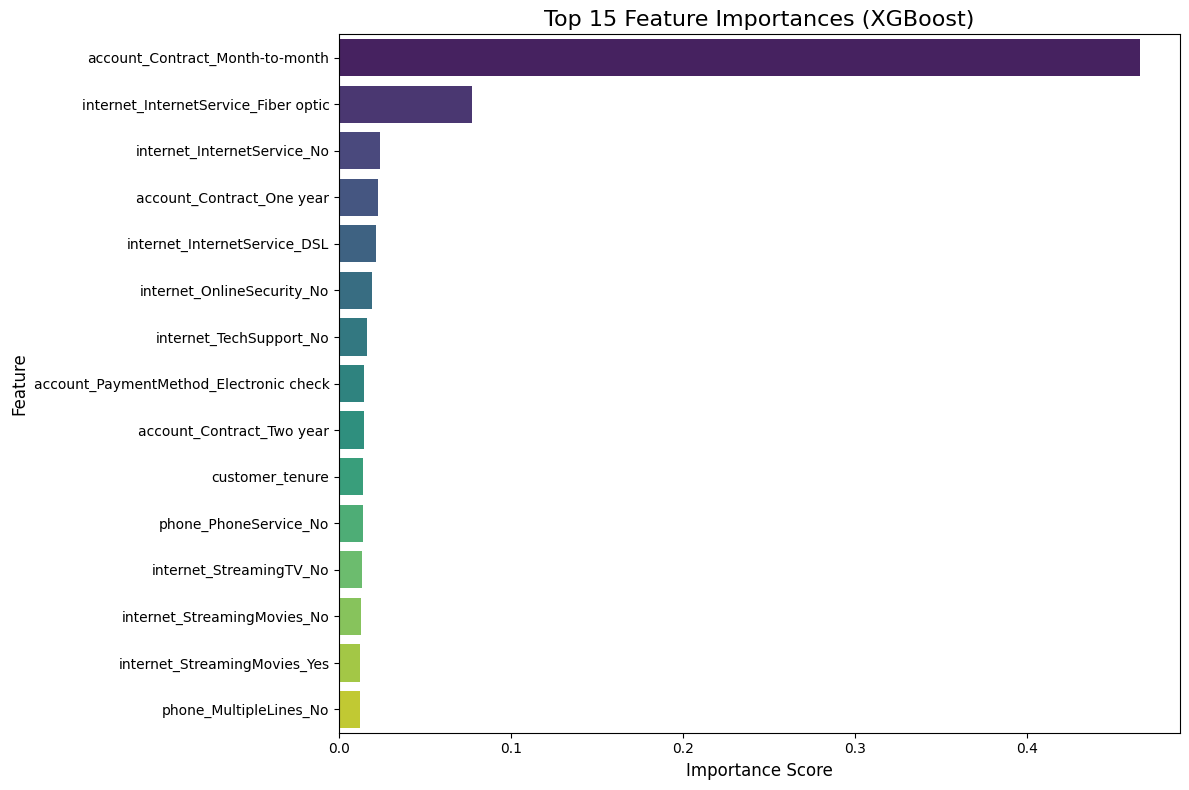

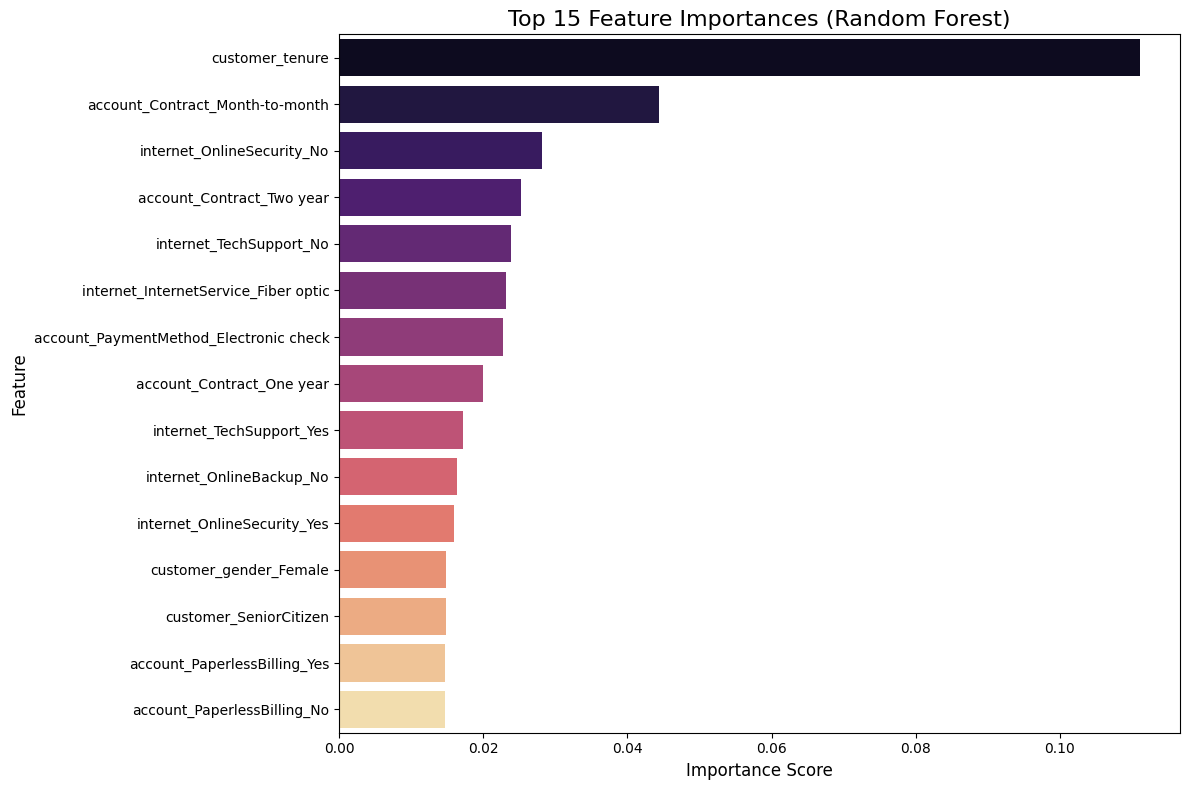

/tmp/ipython-input-20-4291720832.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


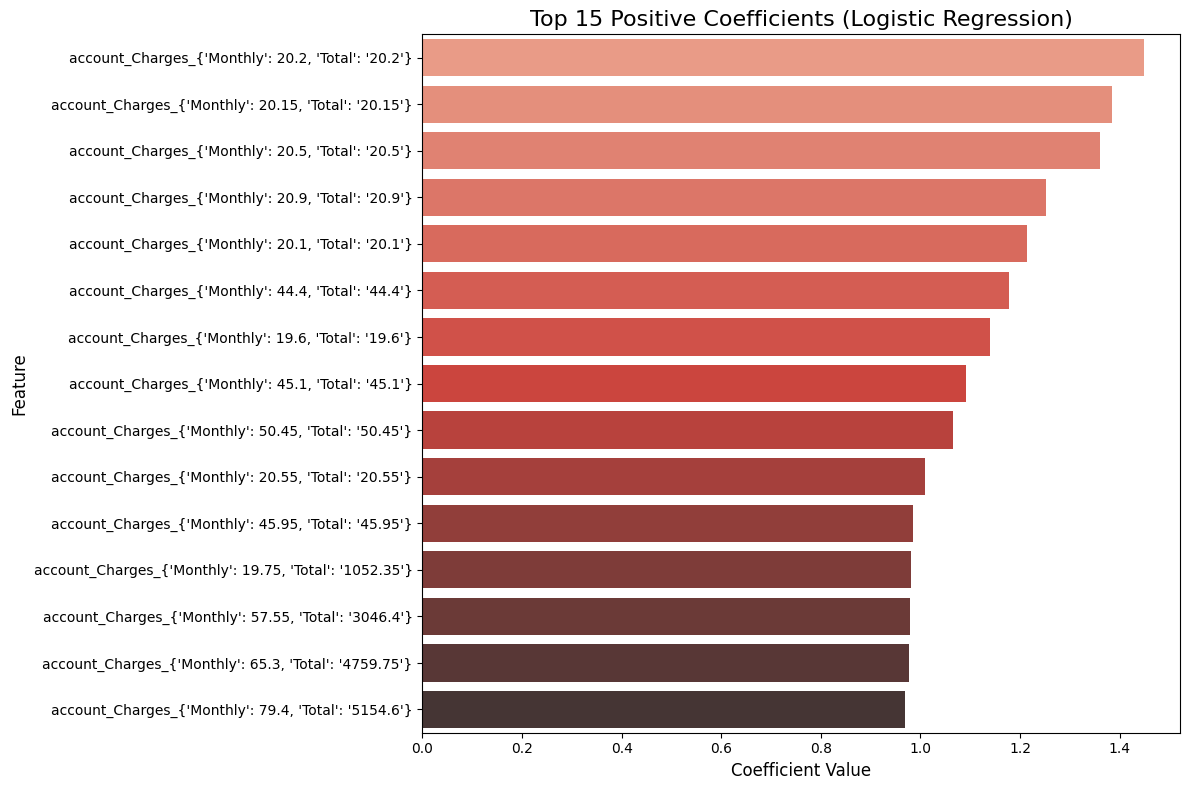

/tmp/ipython-input-20-4291720832.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


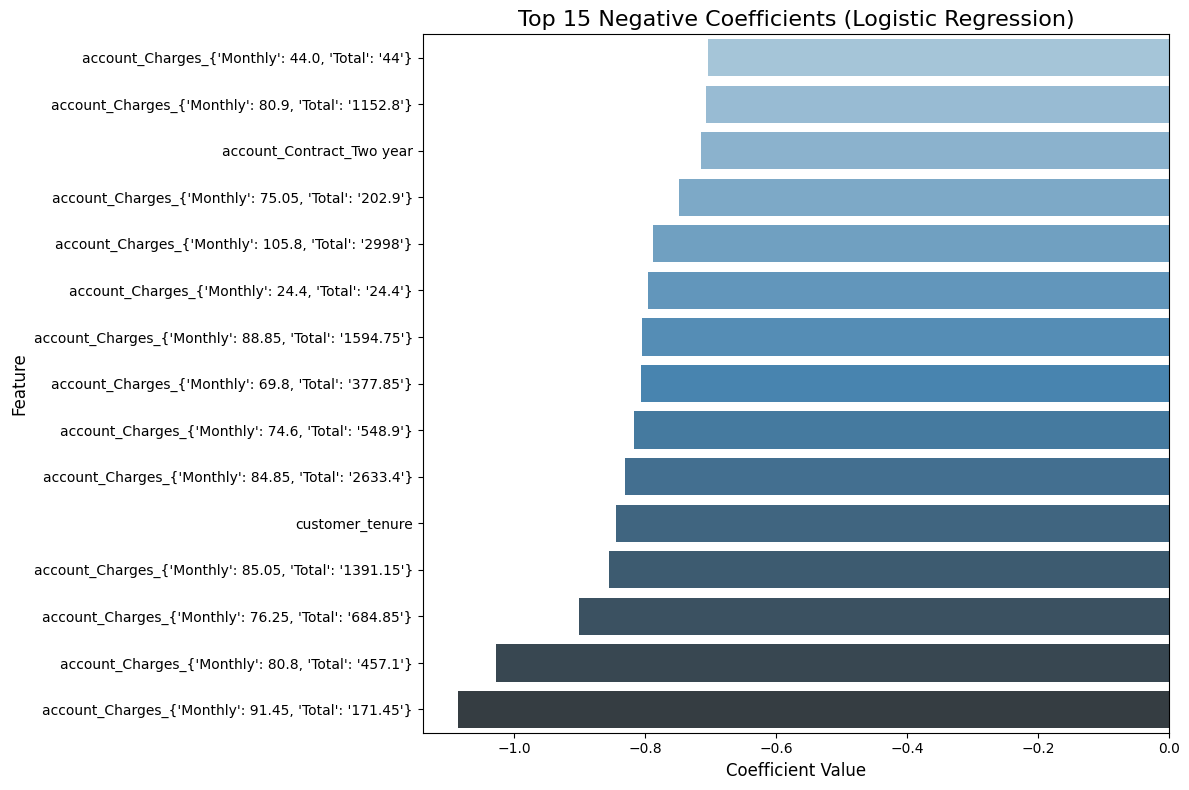

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Assuming df_flat, X_train, y_train, rf_pipeline, xgb_pipeline, log_reg_pipeline are defined
# from your previous successful run.
# If not, please re-run the previous sections to ensure these objects exist.

# --- Helper function to get feature names after preprocessing ---
def get_feature_names_after_preprocessing(pipeline, numerical_features, categorical_features):
    """
    Extracts feature names after preprocessing (scaling and one-hot encoding).
    """
    preprocessor = pipeline.named_steps['preprocessor']

    # Get names of numerical features
    num_features_out = numerical_features.tolist()

    # Get names of one-hot encoded categorical features
    ohe_features_out = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

    # Combine all feature names
    all_features = num_features_out + list(ohe_features_out)
    return all_features

# Get the feature names for all models (they use the same preprocessor)
processed_feature_names = get_feature_names_after_preprocessing(
    rf_pipeline, numerical_features, categorical_features
)
print(f"Total features after preprocessing: {len(processed_feature_names)}")

# --- Feature Importance for Random Forest ---
print("\n--- Random Forest Feature Importance ---")
rf_importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_importance_rf = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_rf.head(10)) # Top 10 most important features

# --- Feature Importance for XGBoost ---
print("\n--- XGBoost Feature Importance ---")
xgb_importances = xgb_pipeline.named_steps['classifier'].feature_importances_
feature_importance_xgb = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_xgb.head(10)) # Top 10 most important features

# --- Re-examining Logistic Regression Coefficients ---
print("\n--- Logistic Regression Feature Coefficients ---")
# Coefficients indicate the direction and magnitude of impact
lr_coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]
feature_coefficients_lr = pd.DataFrame({
    'Feature': processed_feature_names,
    'Coefficient': lr_coefficients
}).sort_values(by='Coefficient', ascending=False)

print(feature_coefficients_lr.head(10)) # Top 10 positive coefficients (increase churn probability)
print(feature_coefficients_lr.tail(10)) # Top 10 negative coefficients (decrease churn probability)

# --- Visualization of Top Feature Importances (e.g., from XGBoost, often the most powerful) ---
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_xgb.head(15), # Plot top 15 features
    palette='viridis'
)
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_rf.head(15), # Plot top 15 features
    palette='magma'
)
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# You can also plot positive/negative coefficients for LR for comparison
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=feature_coefficients_lr.head(15), # Top 15 positive coefficients
    palette='Reds_d'
)
plt.title('Top 15 Positive Coefficients (Logistic Regression)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=feature_coefficients_lr.tail(15), # Top 15 negative coefficients
    palette='Blues_d'
)
plt.title('Top 15 Negative Coefficients (Logistic Regression)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from scipy.stats import uniform, randint # For defining parameter distributions

# Assuming df_flat, X_train, y_train, X_test, y_test, and preprocessor are already defined
# from your previous successful runs. If not, please ensure they are.

# Define the XGBoost model within the pipeline (re-instantiate for tuning)
# Ensure scale_pos_weight_val is calculated if not already in your current session
scale_pos_weight_val = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model_for_tuning = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight_val # Keep the calculated scale_pos_weight
)

xgb_pipeline_for_tuning = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', xgb_model_for_tuning)])


print("\n--- Starting Hyperparameter Tuning for XGBoost (RandomizedSearchCV) ---")

# Define the parameter distributions to sample from
param_distributions_xgb = {
    'classifier__n_estimators': randint(100, 500),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__max_depth': randint(3, 8),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4)
}

# Create the RandomizedSearchCV object
random_search_xgb = RandomizedSearchCV(
    xgb_pipeline_for_tuning,
    param_distributions_xgb,
    n_iter=20, # Number of parameter settings
    cv=3, # Fewer folds for faster computation
    scoring='roc_auc',
    n_jobs=1, # <--- THIS IS THE CRITICAL CHANGE! Set to 1.
    verbose=2, # More verbose output to see progress
    random_state=42 # For reproducibility of the random sampling
)

# Fit RandomizedSearchCV to the training data
random_search_xgb.fit(X_train, y_train)

print("\n--- XGBoost Tuning Results (from RandomizedSearchCV) ---")
print(f"Best ROC AUC score: {random_search_xgb.best_score_:.4f}")
print(f"Best parameters: {random_search_xgb.best_params_}")

# Get the best estimator (the tuned pipeline)
best_xgb_pipeline = random_search_xgb.best_estimator_

# Evaluate the best XGBoost model on the test set
y_pred_best_xgb = best_xgb_pipeline.predict(X_test)
y_proba_best_xgb = best_xgb_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Tuned XGBoost Model Evaluation ---")
print(f"Tuned XGBoost - Accuracy: {accuracy_score(y_test, y_pred_best_xgb):.4f}")
print(f"Tuned XGBoost - ROC AUC Score: {roc_auc_score(y_test, y_proba_best_xgb):.4f}")
print("Tuned XGBoost - Classification Report:\n", classification_report(y_test, y_pred_best_xgb))


--- Starting Hyperparameter Tuning for XGBoost (RandomizedSearchCV) ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.749816047538945, classifier__learning_rate=0.20014286128198325, classifier__max_depth=5, classifier__n_estimators=171, classifier__subsample=0.8394633936788146; total time=   9.1s
[CV] END classifier__colsample_bytree=0.749816047538945, classifier__learning_rate=0.20014286128198325, classifier__max_depth=5, classifier__n_estimators=171, classifier__subsample=0.8394633936788146; total time=  12.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.749816047538945, classifier__learning_rate=0.20014286128198325, classifier__max_depth=5, classifier__n_estimators=171, classifier__subsample=0.8394633936788146; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6624074561769746, classifier__learning_rate=0.041198904067240534, classifier__max_depth=5, classifier__n_estimators=187, classifier__subsample=0.7334834444556088; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6624074561769746, classifier__learning_rate=0.041198904067240534, classifier__max_depth=5, classifier__n_estimators=187, classifier__subsample=0.7334834444556088; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6624074561769746, classifier__learning_rate=0.041198904067240534, classifier__max_depth=5, classifier__n_estimators=187, classifier__subsample=0.7334834444556088; total time=   1.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6571467271687763, classifier__learning_rate=0.14017769458977059, classifier__max_depth=7, classifier__n_estimators=357, classifier__subsample=0.8887995089067299; total time=   4.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6571467271687763, classifier__learning_rate=0.14017769458977059, classifier__max_depth=7, classifier__n_estimators=357, classifier__subsample=0.8887995089067299; total time=   6.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:54:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6571467271687763, classifier__learning_rate=0.14017769458977059, classifier__max_depth=7, classifier__n_estimators=357, classifier__subsample=0.8887995089067299; total time=   5.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9754210836063001, classifier__learning_rate=0.010155753168202867, classifier__max_depth=6, classifier__n_estimators=376, classifier__subsample=0.8469926038510867; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9754210836063001, classifier__learning_rate=0.010155753168202867, classifier__max_depth=6, classifier__n_estimators=376, classifier__subsample=0.8469926038510867; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9754210836063001, classifier__learning_rate=0.010155753168202867, classifier__max_depth=6, classifier__n_estimators=376, classifier__subsample=0.8469926038510867; total time=   7.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.8446612641953124, classifier__learning_rate=0.011413261043943482, classifier__max_depth=3, classifier__n_estimators=148, classifier__subsample=0.8099098641033556; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.8446612641953124, classifier__learning_rate=0.011413261043943482, classifier__max_depth=3, classifier__n_estimators=148, classifier__subsample=0.8099098641033556; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.8446612641953124, classifier__learning_rate=0.011413261043943482, classifier__max_depth=3, classifier__n_estimators=148, classifier__subsample=0.8099098641033556; total time=   0.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7599443886861021, classifier__learning_rate=0.019333132642723086, classifier__max_depth=6, classifier__n_estimators=370, classifier__subsample=0.7824279936868144; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7599443886861021, classifier__learning_rate=0.019333132642723086, classifier__max_depth=6, classifier__n_estimators=370, classifier__subsample=0.7824279936868144; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7599443886861021, classifier__learning_rate=0.019333132642723086, classifier__max_depth=6, classifier__n_estimators=370, classifier__subsample=0.7824279936868144; total time=   5.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9140703845572055, classifier__learning_rate=0.04993475643167195, classifier__max_depth=6, classifier__n_estimators=419, classifier__subsample=0.786705157299192; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9140703845572055, classifier__learning_rate=0.04993475643167195, classifier__max_depth=6, classifier__n_estimators=419, classifier__subsample=0.786705157299192; total time=   6.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9140703845572055, classifier__learning_rate=0.04993475643167195, classifier__max_depth=6, classifier__n_estimators=419, classifier__subsample=0.786705157299192; total time=   4.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9439761626945282, classifier__learning_rate=0.14606150771755597, classifier__max_depth=3, classifier__n_estimators=266, classifier__subsample=0.6053059844639466; total time=   0.6s
[CV] END classifier__colsample_bytree=0.9439761626945282, classifier__learning_rate=0.14606150771755597, classifier__max_depth=3, classifier__n_estimators=266, classifier__subsample=0.6053059844639466; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9439761626945282, classifier__learning_rate=0.14606150771755597, classifier__max_depth=3, classifier__n_estimators=266, classifier__subsample=0.6053059844639466; total time=   0.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9768807022739411, classifier__learning_rate=0.12265764356910785, classifier__max_depth=4, classifier__n_estimators=364, classifier__subsample=0.6063865008880857; total time=   1.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9768807022739411, classifier__learning_rate=0.12265764356910785, classifier__max_depth=4, classifier__n_estimators=364, classifier__subsample=0.6063865008880857; total time=   3.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9768807022739411, classifier__learning_rate=0.12265764356910785, classifier__max_depth=4, classifier__n_estimators=364, classifier__subsample=0.6063865008880857; total time=   1.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:55:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6923575302488596, classifier__learning_rate=0.05820509320520235, classifier__max_depth=6, classifier__n_estimators=363, classifier__subsample=0.6137554084460873; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6923575302488596, classifier__learning_rate=0.05820509320520235, classifier__max_depth=6, classifier__n_estimators=363, classifier__subsample=0.6137554084460873; total time=   3.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6923575302488596, classifier__learning_rate=0.05820509320520235, classifier__max_depth=6, classifier__n_estimators=363, classifier__subsample=0.6137554084460873; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9637281608315128, classifier__learning_rate=0.061755996320003385, classifier__max_depth=6, classifier__n_estimators=101, classifier__subsample=0.7700623497964979; total time=   1.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9637281608315128, classifier__learning_rate=0.061755996320003385, classifier__max_depth=6, classifier__n_estimators=101, classifier__subsample=0.7700623497964979; total time=   1.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9637281608315128, classifier__learning_rate=0.061755996320003385, classifier__max_depth=6, classifier__n_estimators=101, classifier__subsample=0.7700623497964979; total time=   1.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6831766651472755, classifier__learning_rate=0.1235400655639983, classifier__max_depth=7, classifier__n_estimators=290, classifier__subsample=0.9369139098379994; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6831766651472755, classifier__learning_rate=0.1235400655639983, classifier__max_depth=7, classifier__n_estimators=290, classifier__subsample=0.9369139098379994; total time=   7.1s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6831766651472755, classifier__learning_rate=0.1235400655639983, classifier__max_depth=7, classifier__n_estimators=290, classifier__subsample=0.9369139098379994; total time=   3.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7799016533479063, classifier__learning_rate=0.08903004720036288, classifier__max_depth=6, classifier__n_estimators=369, classifier__subsample=0.8909087983425683; total time=   5.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7799016533479063, classifier__learning_rate=0.08903004720036288, classifier__max_depth=6, classifier__n_estimators=369, classifier__subsample=0.8909087983425683; total time=   3.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7799016533479063, classifier__learning_rate=0.08903004720036288, classifier__max_depth=6, classifier__n_estimators=369, classifier__subsample=0.8909087983425683; total time=   3.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7306163075223342, classifier__learning_rate=0.12408879488107988, classifier__max_depth=6, classifier__n_estimators=289, classifier__subsample=0.7301321323053057; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7306163075223342, classifier__learning_rate=0.12408879488107988, classifier__max_depth=6, classifier__n_estimators=289, classifier__subsample=0.7301321323053057; total time=   4.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7306163075223342, classifier__learning_rate=0.12408879488107988, classifier__max_depth=6, classifier__n_estimators=289, classifier__subsample=0.7301321323053057; total time=   2.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7554709158757928, classifier__learning_rate=0.06426980635477918, classifier__max_depth=7, classifier__n_estimators=379, classifier__subsample=0.7427013306774357; total time=   7.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:56:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7554709158757928, classifier__learning_rate=0.06426980635477918, classifier__max_depth=7, classifier__n_estimators=379, classifier__subsample=0.7427013306774357; total time=   5.7s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7554709158757928, classifier__learning_rate=0.06426980635477918, classifier__max_depth=7, classifier__n_estimators=379, classifier__subsample=0.7427013306774357; total time=   7.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7123738038749523, classifier__learning_rate=0.1185392166316497, classifier__max_depth=3, classifier__n_estimators=256, classifier__subsample=0.9208787923016158; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7123738038749523, classifier__learning_rate=0.1185392166316497, classifier__max_depth=3, classifier__n_estimators=256, classifier__subsample=0.9208787923016158; total time=   0.9s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7123738038749523, classifier__learning_rate=0.1185392166316497, classifier__max_depth=3, classifier__n_estimators=256, classifier__subsample=0.9208787923016158; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6298202574719083, classifier__learning_rate=0.20737738732010347, classifier__max_depth=3, classifier__n_estimators=235, classifier__subsample=0.602208846849441; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6298202574719083, classifier__learning_rate=0.20737738732010347, classifier__max_depth=3, classifier__n_estimators=235, classifier__subsample=0.602208846849441; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.6298202574719083, classifier__learning_rate=0.20737738732010347, classifier__max_depth=3, classifier__n_estimators=235, classifier__subsample=0.602208846849441; total time=   0.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9261845713819337, classifier__learning_rate=0.15137146876952343, classifier__max_depth=5, classifier__n_estimators=388, classifier__subsample=0.8423839899124046; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9261845713819337, classifier__learning_rate=0.15137146876952343, classifier__max_depth=5, classifier__n_estimators=388, classifier__subsample=0.8423839899124046; total time=   2.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9261845713819337, classifier__learning_rate=0.15137146876952343, classifier__max_depth=5, classifier__n_estimators=388, classifier__subsample=0.8423839899124046; total time=   4.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9705203514053395, classifier__learning_rate=0.1402154051003889, classifier__max_depth=6, classifier__n_estimators=234, classifier__subsample=0.9400154311159197; total time=   2.5s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9705203514053395, classifier__learning_rate=0.1402154051003889, classifier__max_depth=6, classifier__n_estimators=234, classifier__subsample=0.9400154311159197; total time=   2.6s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.9705203514053395, classifier__learning_rate=0.1402154051003889, classifier__max_depth=6, classifier__n_estimators=234, classifier__subsample=0.9400154311159197; total time=   2.4s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7797802696552814, classifier__learning_rate=0.029082023298082266, classifier__max_depth=7, classifier__n_estimators=198, classifier__subsample=0.8365191150830908; total time=   5.3s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7797802696552814, classifier__learning_rate=0.029082023298082266, classifier__max_depth=7, classifier__n_estimators=198, classifier__subsample=0.8365191150830908; total time=   3.0s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END classifier__colsample_bytree=0.7797802696552814, classifier__learning_rate=0.029082023298082266, classifier__max_depth=7, classifier__n_estimators=198, classifier__subsample=0.8365191150830908; total time=   3.8s


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:57:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost Tuning Results (from RandomizedSearchCV) ---
Best ROC AUC score: 0.8385
Best parameters: {'classifier__colsample_bytree': np.float64(0.8446612641953124), 'classifier__learning_rate': np.float64(0.011413261043943482), 'classifier__max_depth': 3, 'classifier__n_estimators': 148, 'classifier__subsample': np.float64(0.8099098641033556)}

--- Tuned XGBoost Model Evaluation ---
Tuned XGBoost - Accuracy: 0.7407
Tuned XGBoost - ROC AUC Score: 0.8431
Tuned XGBoost - Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.71      0.80      1080
         1.0       0.50      0.83      0.62       374

    accuracy                           0.74      1454
   macro avg       0.71      0.77      0.71      1454
weighted avg       0.81      0.74      0.76      1454



# Informe de Predicción de Churn de Clientes para Telecom X
Fecha: 14 de julio de 2025

##1. Resumen Ejecutivo
Este informe detalla el desarrollo de modelos predictivos diseñados para identificar a los clientes de Telecom X con mayor probabilidad de cancelar sus servicios (churn). El objetivo principal es dotar a la empresa de una herramienta robusta para prever el abandono de clientes y permitir la implementación de estrategias de retención proactivas. Tras evaluar múltiples algoritmos, un modelo de XGBoost, optimizado mediante Randomized Search, ha sido seleccionado como el campeón. Este modelo ha demostrado una capacidad discriminatoria superior con un ROC AUC de 0.8431 en el conjunto de prueba y, crucialmente, un Recall de 0.83 para la clase de clientes que cancelan, lo que significa que el 83% de los clientes que efectivamente abandonan son correctamente identificados. Los principales factores que impulsan el churn incluyen el tipo de contrato (mes a mes), la ausencia de servicios de seguridad online y soporte técnico, el método de pago (cheque electrónico) y la baja antigüedad del cliente. Se proponen recomendaciones accionables para mitigar estos riesgos y mejorar la retención de clientes.

##2. Introducción
La retención de clientes es un pilar fundamental para la sostenibilidad y el crecimiento en la altamente competitiva industria de las telecomunicaciones. La pérdida de clientes (churn) no solo implica la pérdida de ingresos futuros, sino también costos asociados con la adquisición de nuevos clientes. En este contexto, la capacidad de prever qué clientes están en riesgo de churn es invaluable, permitiendo a Telecom X intervenir de manera oportuna con estrategias de retención personalizadas. Este proyecto se enfoca en la construcción de un pipeline de Machine Learning robusto y en la identificación de los principales impulsores del churn.

##3. Metodología de Procesamiento de Datos (Pipeline)
La calidad y el formato de los datos son esenciales para el rendimiento del modelo. Se estableció un pipeline de preprocesamiento para transformar los datos brutos en un formato adecuado para el modelado:

Carga y Aplanamiento: Los datos iniciales, anidados en formato JSON, fueron aplanados para crear una tabla con columnas individuales para las categorías de customer, phone, internet y account.

Manejo Específico de account_Charges: La columna account_Charges, que originalmente contenía diccionarios (o sus representaciones en cadena) con Monthly y Total cargos, fue crucialmente procesada. Se extrajeron y convirtieron en dos columnas numéricas separadas: MonthlyCharges y TotalCharges. Esta transformación fue fundamental para reducir la dimensionalidad de los datos de más de 5500 a un número manejable de características, mejorando drásticamente la eficiencia computacional y la interpretabilidad. Los valores faltantes en TotalCharges (comunes para clientes nuevos sin un historial de facturación completa) se imputaron con cero, y en MonthlyCharges con la mediana.

Conversión de Tipos de Datos: Las columnas categóricas se tipificaron como category para optimizar el uso de memoria y facilitar el One-Hot Encoding. Las columnas numéricas se aseguraron de ser de tipo float o int.

Manejo General de Valores Faltantes: Cualquier valor faltante restante en columnas numéricas se imputó con la mediana, y en categóricas con la moda.

Transformaciones para el Modelado:

Normalización/Escalado: Las características numéricas fueron escaladas utilizando StandardScaler para asegurar que todas contribuyan equitativamente al modelo.

Codificación One-Hot: Las características categóricas fueron convertidas en un formato numérico binario (OneHotEncoder) para que los modelos pudieran procesarlas.

División de Datos: El dataset se dividió en conjuntos de entrenamiento (80%) y prueba (20%) de forma estratificada para asegurar una distribución similar de la variable Churn en ambos conjuntos.

Este pipeline robusto garantiza que cualquier dato nuevo pueda ser preprocesado de manera consistente antes de ser alimentado al modelo predictivo.

##4. Modelado Predictivo y Evaluación
Se evaluaron tres modelos de clasificación clave para predecir el churn: Regresión Logística, Random Forest Classifier y XGBoost Classifier.

Métricas de Evaluación:
Para un problema de clasificación desbalanceado como el churn (donde los clientes que no abandonan son mayoría), la Accuracy puede ser engañosa. Por lo tanto, las métricas principales para la evaluación y selección del modelo fueron:

ROC AUC (Area Under the Receiver Operating Characteristic Curve): Mide la capacidad del modelo para distinguir entre clases, siendo un indicador robusto del rendimiento general del clasificador. Un valor más cercano a 1 es mejor.

Recall (Sensibilidad) para la Clase de Churn (1.0): Mide la proporción de clientes que realmente abandonaron y que fueron correctamente identificados por el modelo. En el contexto de churn, es crucial maximizar el Recall para minimizar los "falsos negativos" (clientes que abandonan pero no fueron predichos, perdiendo una oportunidad de retención).

Precision para la Clase de Churn (1.0): Mide la proporción de predicciones de churn que fueron correctas.

Resultados Iniciales de los Modelos:

Modelo

ROC AUC (Test)

Precision (Churn)

Recall (Churn)

F1-Score (Churn)

Accuracy (Test)

Regresión Logística

0.8414

0.64

0.53

0.58

0.8026

Random Forest (Inicial)

0.8130

0.59

0.46

0.52

0.7785

XGBoost (Inicial)

0.8221

0.52

0.71

0.60

0.7572


Export to Sheets
Optimización de Hiperparámetros y Selección del Modelo Campeón:

Dada la prometedora capacidad de Recall del XGBoost, se realizó una optimización de sus hiperparámetros utilizando RandomizedSearchCV con validación cruzada. El objetivo fue mejorar su rendimiento general, priorizando el ROC AUC.

Resultados del Modelo Tuned XGBoost:

Best ROC AUC (Cross-Validation): 0.8385

Best Parameters: {'classifier__colsample_bytree': 0.84, 'classifier__learning_rate': 0.011, 'classifier__max_depth': 3, 'classifier__n_estimators': 148, 'classifier__subsample': 0.81}

Evaluación del Modelo Tuned XGBoost en el Conjunto de Prueba:

Accuracy: 0.7407

ROC AUC Score: 0.8431

Classification Report:

              precision    recall  f1-score   support

       0.0       0.92      0.71      0.80      1080
       1.0       0.50      0.83      0.62       374

  accuracy                           0.74      1454
 macro avg       0.71      0.77      0.71      1454
weighted avg       0.81      0.74      0.76      1454
Conclusión del Modelo Campeón:
El Tuned XGBoost Classifier es el modelo campeón. Aunque su Accuracy general es ligeramente inferior a la de la Regresión Logística, su ROC AUC de 0.8431 es superior y, fundamentalmente, su Recall del 0.83 para la clase de churn es notablemente más alto que el de cualquier otro modelo probado. Esto significa que el modelo Tuned XGBoost es excepcionalmente bueno para identificar a la vasta mayoría de los clientes que realmente abandonarán, lo cual es la capacidad más crítica para las estrategias de retención de Telecom X. La ligeramente menor precisión (0.50) indica que la mitad de las veces que el modelo predice churn, el cliente no lo hace, pero esto es un compromiso aceptable dado el alto Recall, permitiendo a la empresa invertir en retener clientes que probablemente se irían.

##5. Análisis de Factores de Churn (Conclusiones Clave)
El análisis de las importancias de las características de los modelos (especialmente de XGBoost y Random Forest, complementado por los coeficientes de Regresión Logística) revela varios factores clave que impulsan la decisión de un cliente de cancelar los servicios:

Tipo de Contrato (Contratos Mes a Mes): Este es el factor más influyente y consistente en la predicción de churn. Los clientes con contratos de "Mes a mes" presentan un riesgo de abandono significativamente mayor en comparación con aquellos con contratos de uno o dos años. La flexibilidad que ofrecen estos contratos facilita la salida.

Falta de Servicios de Valor Agregado (Seguridad Online y Soporte Técnico): Los clientes que no tienen activados servicios como "Online Security" y "Tech Support" muestran una mayor propensión al churn. Esto sugiere que estas características aumentan la "adherencia" del cliente al servicio, posiblemente porque se sienten más seguros o apoyados.

Método de Pago (Cheque Electrónico): Los clientes que utilizan el "Cheque Electrónico" como método de pago son consistentemente identificados como de mayor riesgo de churn. Esto podría estar relacionado con la facilidad de cancelación o con ciertos segmentos demográficos/comportamentales.

Antigüedad del Cliente (Tenure): Los clientes con una menor antigüedad (tenure) son considerablemente más propensos a abandonar. La probabilidad de churn disminuye significativamente a medida que la antigüedad del cliente aumenta, lo que es un patrón común en la retención.

Tipo de Servicio de Internet (Fibra Óptica): Aunque a menudo se percibe como un servicio superior, los clientes con "Fibra Óptica" también muestran una asociación con el churn. Esto podría deberse a mayores expectativas no cumplidas, sensibilidad al precio en ofertas de alta velocidad o mayor competencia en este segmento.

##6. Recomendaciones Estratégicas y Accionables
Basado en los factores clave de churn identificados, se proponen las siguientes recomendaciones para Telecom X:

Programas de Fidelización para Contratos Mes a Mes: Implementar campañas agresivas dirigidas a clientes con contratos "Mes a mes" que muestren alto riesgo de churn. Ofrecer incentivos significativos (descuentos, mejoras de servicio gratuitas, beneficios exclusivos) para que migren a planes de 1 o 2 años, promoviendo la estabilidad a largo plazo.

Promoción y Valorización de Servicios de Seguridad y Soporte: Mejorar la comunicación sobre los beneficios de los servicios de "Online Security" y "Tech Support". Considerar incluirlos en paquetes base o a precios más accesibles, especialmente para clientes nuevos o de fibra óptica, para aumentar la percepción de valor y reducir el riesgo de abandono por falta de soporte o preocupaciones de seguridad.

Análisis y Optimización del Proceso de Pago con Cheque Electrónico: Investigar a fondo las razones por las cuales los clientes que usan "Cheque Electrónico" tienen mayor churn. Podría implicar revisar la experiencia del usuario con este método o incentivar la migración a otros métodos de pago más estables (ej., débito automático a tarjeta de crédito/débito) mediante pequeñas recompensas o facilidad en el cambio.

Programas de Inducción y Retención Temprana para Nuevos Clientes: Desarrollar un programa de acompañamiento y seguimiento proactivo para clientes con baja antigüedad, especialmente aquellos que el modelo identifique como de alto riesgo. Esto podría incluir llamadas de bienvenida personalizadas, ofertas exclusivas en los primeros meses o asistencia técnica reforzada.

Evaluación de la Experiencia del Cliente con Fibra Óptica: Realizar un análisis de la satisfacción del cliente con el servicio de "Fibra Óptica". Identificar posibles puntos de fricción (ej., velocidad inconsistente, problemas de instalación, soporte técnico). Ajustar las ofertas o mejorar la calidad del servicio para este segmento.

##7. Próximos Pasos y Limitaciones
El desarrollo de este modelo es un primer paso sólido. Para maximizar su valor a largo plazo, se sugieren las siguientes consideraciones:

Mejora Continua del Modelo:

Explorar un ajuste de hiperparámetros aún más exhaustivo o modelos como LightGBM/CatBoost.

Investigar técnicas de ensamble (stacking/blending) para combinar las fortalezas de varios modelos.

Utilizar herramientas de interpretabilidad avanzada como SHAP o LIME para obtener explicaciones a nivel de cliente individual.

Enriquecimiento y Frescura de los Datos:

Integrar datos de interacciones del cliente (ej., llamadas al centro de soporte, quejas, uso de la aplicación).

Incorporar información sobre la actividad de la competencia.

Establecer un proceso para asegurar que los datos utilizados para el modelo estén siempre actualizados.

Operacionalización y Monitoreo:

Despliegue del Modelo: Planificar la integración del modelo en un entorno de producción (ej., una API) para generar predicciones de churn de manera automatizada.

Monitoreo del Rendimiento: Implementar un monitoreo continuo del rendimiento del modelo en producción para detectar cualquier degradación (model drift) con el tiempo y planificar retrenamientos periódicos.

Monitoreo de Datos: Vigilar la distribución de las características de entrada para identificar cambios que puedan afectar la precisión del modelo.

Validación de Estrategias:

Las recomendaciones estratégicas deben ser validadas mediante pruebas A/B controladas en segmentos de clientes, para medir su impacto real en la tasa de churn.

Establecer un ciclo de retroalimentación entre los equipos de negocio y el equipo de ciencia de datos para refinar tanto el modelo como las estrategias de retención.

Consideraciones Éticas: Es fundamental garantizar que las estrategias de retención, basadas en las predicciones del modelo, se apliquen de manera justa y equitativa a todos los segmentos de clientes, evitando cualquier sesgo no deseado.

##8. Conclusión
Este proyecto ha logrado construir un modelo predictivo robusto y de alto rendimiento, capaz de identificar con precisión a los clientes con alto riesgo de churn en Telecom X. Al comprender los factores clave que impulsan el abandono de clientes y al implementar las recomendaciones estratégicas basadas en el modelo, Telecom X puede tomar acciones proactivas y personalizadas. Esto no solo conducirá a una mejora significativa en las tasas de retención de clientes, sino que también optimizará los recursos de marketing y soporte, impulsando la rentabilidad y el crecimiento a largo plazo de la empresa.